<a href="https://colab.research.google.com/github/BozidarM/Hand-gestures-classification-with-Pytorch/blob/main/Gestures_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Downloading dataset form kaggle
!mkdir -p /root/.kaggle/
!echo '{"username":"bozidarmladenovic99","key":"4203dd90109ce3f02891cb6e45413b2b"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d innominate817/hagrid-classification-512p-no-gesture-150k

100% 3.54G/3.55G [00:48<00:00, 135MB/s]
100% 3.55G/3.55G [00:48<00:00, 78.8MB/s]


In [ ]:
#Extracting downloaded dataset
!unzip -q hagrid-classification-512p-no-gesture-150k.zip -d ./

In [ ]:
#Rename folder for easier access
!mv hagrid-classification-512p-no-gesture-150k gestures

In [ ]:
#Required imports
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import shutil

#Parent directory for images
parent_directory = '/content/gestures'

In [ ]:
#Connecting colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla T4 is available


In [ ]:
#Geting info about number of folders and files
class_counter=0;
class_list = [];
for folder_name in os.listdir(parent_directory):
    folder_path = os.path.join(parent_directory, folder_name)
    if os.path.isdir(folder_path):
        class_counter += 1
        file_count = len(os.listdir(folder_path))
        class_list.append(folder_name)
        print(f"Folder: {folder_name}\tFiles: {file_count}")
print(f"Number of classes: {class_counter}")
class_list

Folder: ok	Files: 6924
Folder: call	Files: 6939
Folder: rock	Files: 6883
Folder: dislike	Files: 7028
Folder: one	Files: 7062
Folder: fist	Files: 6882
Folder: like	Files: 6823
Folder: two_up_inverted	Files: 6967
Folder: peace_inverted	Files: 6876
Folder: two_up	Files: 7346
Folder: mute	Files: 7139
Folder: palm	Files: 7050
Folder: stop_inverted	Files: 7142
Folder: four	Files: 7183
Folder: three2	Files: 6870
Folder: no_gesture	Files: 27823
Folder: stop	Files: 6893
Folder: three	Files: 6940
Folder: peace	Files: 6965
Number of classes: 19


['ok',
 'call',
 'rock',
 'dislike',
 'one',
 'fist',
 'like',
 'two_up_inverted',
 'peace_inverted',
 'two_up',
 'mute',
 'palm',
 'stop_inverted',
 'four',
 'three2',
 'no_gesture',
 'stop',
 'three',
 'peace']

In [ ]:
#Cheking file types in each directory
for root, dirs, files in os.walk(parent_directory):
    if root != parent_directory and files:
        first_file_type = os.path.splitext(files[0])[1]
        for file_name in files:
            file_type = os.path.splitext(file_name)[1]
            if file_type != first_file_type:
                print(f"Files in directory {root} have different types.")
                break
        else:
            print(f"All files in directory {root} have the same type.")

All files in directory /content/gestures/one have the same type.
All files in directory /content/gestures/four have the same type.
All files in directory /content/gestures/rock have the same type.
All files in directory /content/gestures/two_up have the same type.
All files in directory /content/gestures/two_up_inverted have the same type.
All files in directory /content/gestures/like have the same type.
All files in directory /content/gestures/peace_inverted have the same type.
All files in directory /content/gestures/peace have the same type.
All files in directory /content/gestures/ok have the same type.
All files in directory /content/gestures/stop have the same type.
All files in directory /content/gestures/stop_inverted have the same type.
All files in directory /content/gestures/three2 have the same type.
All files in directory /content/gestures/fist have the same type.
All files in directory /content/gestures/dislike have the same type.
All files in directory /content/gestures/

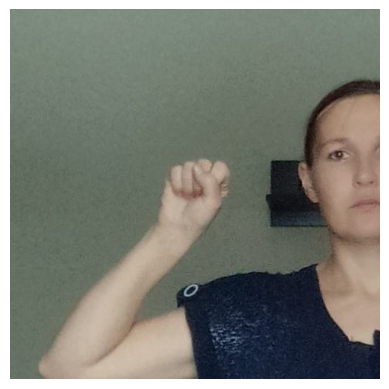

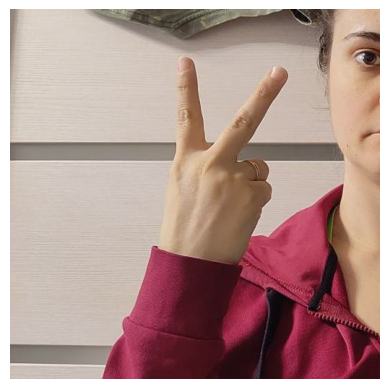

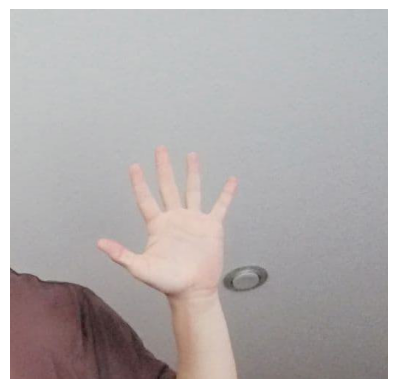

In [ ]:
# Randomly select three different classes
selected_classes = random.sample(class_list, k=3)

# Iterate over the selected classes and choose one random image from each class
for class_name in selected_classes:
    class_directory = os.path.join(parent_directory, class_name)
    image_list = os.listdir(class_directory)
    random_image = random.choice(image_list)
    image_path = os.path.join(class_directory, random_image)

    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

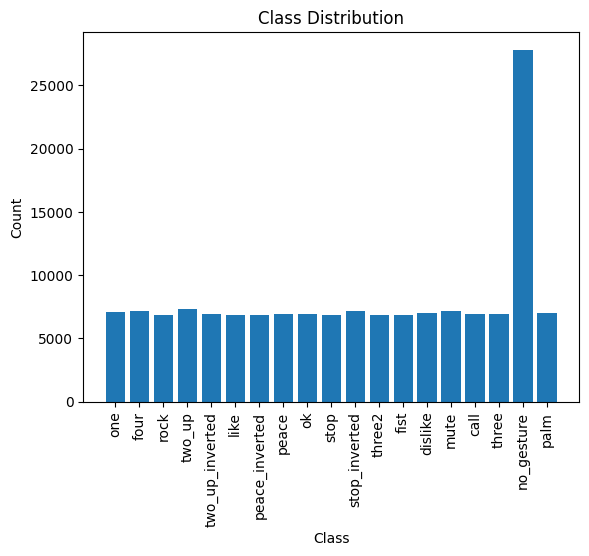

In [ ]:
# Counting the number of images in each class directory
class_counts = {}
for class_name in os.listdir(parent_directory):
    class_directory = os.path.join(parent_directory, class_name)
    if os.path.isdir(class_directory):
        class_counts[class_name] = len(os.listdir(class_directory))

# Plotting the bar chart
class_names = list(class_counts.keys())
class_values = list(class_counts.values())

plt.bar(class_names, class_values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Rotating the x-axis labels if needed
plt.xticks(rotation=90)

# Displaying the plot
plt.show()

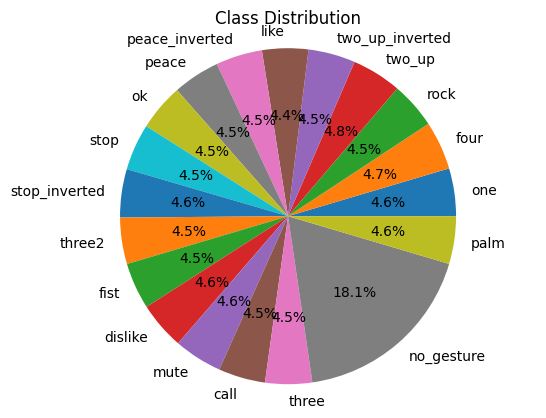

In [ ]:
# Plotting the pie chart
class_names = list(class_counts.keys())
class_values = list(class_counts.values())

plt.pie(class_values, labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class Distribution')

# Displaying the plot
plt.show()

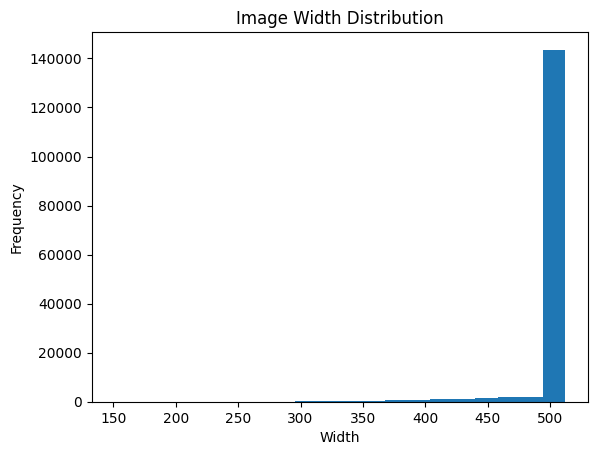

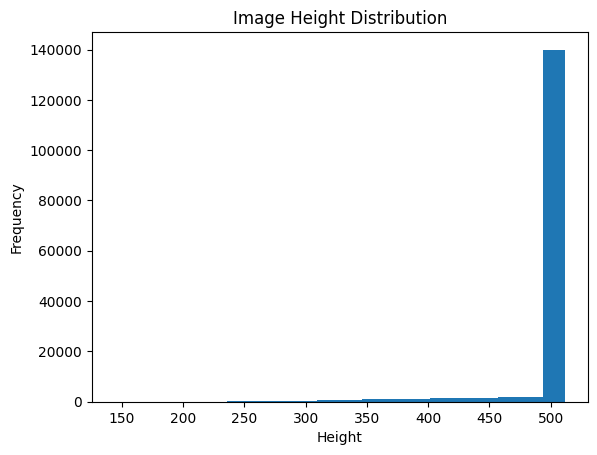

In [ ]:
# Lists to store the widths and heights of images
image_widths = []
image_heights = []

# Iterate over the class directories and collect image dimensions
for class_name in os.listdir(parent_directory):
    class_directory = os.path.join(parent_directory, class_name)
    if os.path.isdir(class_directory):
        for image_name in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_name)
            if os.path.isfile(image_path):
                image = plt.imread(image_path)
                height, width, _ = image.shape
                image_widths.append(width)
                image_heights.append(height)

#Creating the histogram for image widths
plt.hist(image_widths, bins=20)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Image Width Distribution')

# Displaying the plot
plt.show()

# Creating the histogram for image heights
plt.hist(image_heights, bins=20)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Image Height Distribution')

# Displaying the plot
plt.show()

In [ ]:
#Reduce dataset data - because train time and colab session
limited_dataset_path = '/content/limited_dataset'
max_images_per_class = 2000

class_folders = os.listdir(parent_directory)

for class_folder in class_folders:
    if os.path.isdir(parent_directory + '/' + class_folder):
      class_path = os.path.join(parent_directory, class_folder)
      output_class_path = os.path.join(limited_dataset_path, class_folder)
      os.makedirs(output_class_path, exist_ok=True)

      images = os.listdir(class_path)
      selected_images = images[:max_images_per_class]

      for image in selected_images:
          image_path = os.path.join(class_path, image)
          output_image_path = os.path.join(output_class_path, image)
          shutil.copy(image_path, output_image_path)

In [ ]:
#Hand detection model
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 42.2 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
from google.colab.patches import cv2_imshow

mp_hands = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

cropped_dataset_path = '/content/cropped_dataset'

class_folders = os.listdir(limited_dataset_path)

# Process images in each folder
for class_folder in class_folders:
  if os.path.isdir(limited_dataset_path + '/' + class_folder):
    class_input_folder_path = os.path.join(limited_dataset_path, class_folder)
    class_output_folder_path = os.path.join(cropped_dataset_path, class_folder)
    os.makedirs(class_output_folder_path, exist_ok=True)

    # Process images in the current folder
    for file_name in os.listdir(class_input_folder_path):
        file_path = os.path.join(class_input_folder_path, file_name)

        image = cv2.imread(file_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = mp_hands.process(image_rgb)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            image_height, image_width, _ = image.shape

            # Extract hand region coordinates
            landmark_points = []
            for landmark in hand_landmarks.landmark:
                x = int(landmark.x * image_width)
                y = int(landmark.y * image_height)
                landmark_points.append((x, y))

            # Find bounding box coordinates around the hand region
            x_min = min(landmark_points, key=lambda point: point[0])[0]
            y_min = min(landmark_points, key=lambda point: point[1])[1]
            x_max = max(landmark_points, key=lambda point: point[0])[0]
            y_max = max(landmark_points, key=lambda point: point[1])[1]

            # Extend the bounding box coordinates
            padding = 40  # Number of pixels to add as padding
            x_min -= padding
            y_min -= padding
            x_max += padding
            y_max += padding

            # Ensure the coordinates are within the image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image_width, x_max)
            y_max = min(image_height, y_max)

            # Crop the hand region from the image
            hand_image = image[y_min:y_max, x_min:x_max]

             # Save the cropped hand image to the output folder
            output_file_path = os.path.join(class_output_folder_path, file_name)
            cv2.imwrite(output_file_path, hand_image)

# Release resources
mp_hands.close()

In [ ]:
#Geting info about number of folders and files in cropped folder
class_list = [];
for folder_name in os.listdir(cropped_dataset_path):
    folder_path = os.path.join(cropped_dataset_path, folder_name)
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        class_list.append(folder_name)
        print(f"Folder: {folder_name}\tFiles: {file_count}")

Folder: one	Files: 1484
Folder: four	Files: 1517
Folder: rock	Files: 1446
Folder: two_up	Files: 1560
Folder: two_up_inverted	Files: 1379
Folder: like	Files: 1216
Folder: peace_inverted	Files: 1480
Folder: peace	Files: 1488
Folder: ok	Files: 1448
Folder: stop	Files: 1475
Folder: stop_inverted	Files: 1420
Folder: three2	Files: 1634
Folder: fist	Files: 1341
Folder: dislike	Files: 1257
Folder: mute	Files: 1362
Folder: call	Files: 1203
Folder: three	Files: 1482
Folder: no_gesture	Files: 1083
Folder: palm	Files: 1483


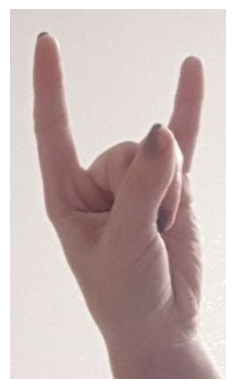

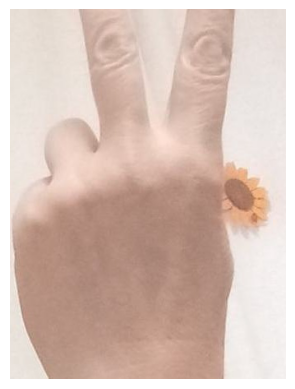

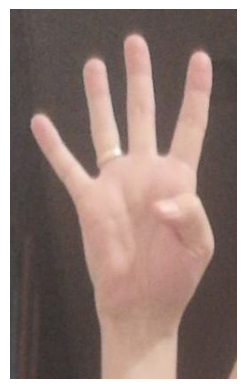

In [ ]:
# Randomly select three different classes
selected_classes = random.sample(class_list, k=3)

# Iterate over the selected classes and choose one random image from each class
for class_name in selected_classes:
    class_directory = os.path.join(cropped_dataset_path, class_name)
    image_list = os.listdir(class_directory)
    random_image = random.choice(image_list)
    image_path = os.path.join(class_directory, random_image)

    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
# Set the random seed for operations
seed = 24
torch.manual_seed(seed)

# Check if CUDA is available and set the random seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
train_ratio = 0.7  # 70% of the data for training
test_ratio = 0.15  # 15% of the data for testing
valid_ratio = 0.15  # 15% of the data for validation

# Loading the dataset using ImageFolder
dataset = ImageFolder(cropped_dataset_path)

# Spliting the dataset into train, test, and validation sets
num_samples = len(dataset)
train_size = int(num_samples * train_ratio)
test_size = int(num_samples * test_ratio)
valid_size = num_samples - train_size - test_size

train_set, test_set, valid_set = random_split(dataset, [train_size, test_size, valid_size])

print("Train set size:", len(train_set))
print("Test set size:", len(test_set))
print("Validation set size:", len(valid_set))

Train set size: 18660
Test set size: 3998
Validation set size: 4000


In [ ]:
# Define the transformations for each set
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),   # Resize the image to a larger size
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Add color jitter
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize image pixels
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Apply transformations to each set
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform
valid_set.dataset.transform = valid_transform

print('Train Tensor: ')
train_set[0]

Train Tensor: 


(tensor([[[ 1.4098,  1.4269,  1.4269,  ..., -0.3883, -0.4054, -0.4054],
          [ 1.4098,  1.4269,  1.4269,  ..., -0.4054, -0.4226, -0.4397],
          [ 1.4098,  1.4269,  1.4269,  ..., -0.4054, -0.4568, -0.4911],
          ...,
          [ 1.2043,  1.2385,  1.2557,  ..., -1.2274, -1.2274, -1.2445],
          [ 1.2214,  1.2385,  1.2385,  ..., -1.2274, -1.2274, -1.2445],
          [ 1.2557,  1.2385,  1.2385,  ..., -1.2445, -1.2445, -1.2617]],
 
         [[ 0.8880,  0.9055,  0.9055,  ..., -0.5826, -0.6001, -0.6001],
          [ 0.8880,  0.9055,  0.9055,  ..., -0.6001, -0.6176, -0.6352],
          [ 0.8880,  0.9055,  0.9055,  ..., -0.6001, -0.6527, -0.6877],
          ...,
          [ 0.6078,  0.6429,  0.6604,  ..., -1.1429, -1.1429, -1.1604],
          [ 0.6254,  0.6429,  0.6429,  ..., -1.1429, -1.1429, -1.1604],
          [ 0.6604,  0.6429,  0.6429,  ..., -1.1604, -1.1604, -1.1779]],
 
         [[ 0.4265,  0.4439,  0.4439,  ..., -0.5670, -0.5844, -0.5844],
          [ 0.4265,  0.4439,

In [ ]:
# Define batch size for training
batch_size = 64

# Creating data loaders for train, test, and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)
validation_loader = DataLoader(valid_set, batch_size=batch_size)

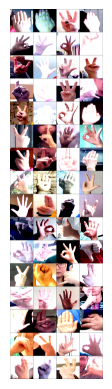

In [ ]:
# Get a batch of images
batch = next(iter(train_loader))

# Extract the images and labels from the batch
images, labels = batch

# Unnormalize the images if they were previously normalized
unnormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
images = unnormalize(images)

# Create a grid of images
grid = torchvision.utils.make_grid(images, nrow=4)

# Convert the grid tensor to a numpy array
grid = grid.numpy().transpose((1, 2, 0))

# Show the grid of images
plt.imshow(grid)
plt.axis('off')
plt.show()

In [ ]:
#loading model 1
model = torchvision.models.efficientnet_v2_s(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 213MB/s]


In [ ]:
# freezeing the weights of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Ensuring the model is suitable for the number of classes in dataset
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, class_counter)

# Moving the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")

model

Model is on GPU


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
import re

train_accuracy_list = []
train_loss_list = []
validation_accuracy_list = []
validation_loss_list = []


# Define the string
string = """Current Learning Rate: 0.001
Validation loss: 1.43
Validation accuracy: 62.37%
Epoch:  1
Train loss: 1.78
Train accuracy: 44.62%
Validation loss: 1.16
Validation accuracy: 66.28%
Epoch:  2
Train loss: 1.24
Train accuracy: 59.01%
Validation loss: 1.07
Validation accuracy: 68.77%
Epoch:  3
Train loss: 1.34
Train accuracy: 62.44%
Validation loss: 0.97
Validation accuracy: 70.31%
Epoch:  4
Train loss: 1.08
Train accuracy: 64.26%
Validation loss: 0.94
Validation accuracy: 70.24%
Epoch:  5
Train loss: 1.17
Train accuracy: 65.06%
Validation loss: 0.89
Validation accuracy: 70.51%
Epoch:  6
Train loss: 0.92
Train accuracy: 66.12%
Validation loss: 0.87
Validation accuracy: 71.41%
Epoch:  7
Train loss: 0.95
Train accuracy: 66.93%
Validation loss: 0.87
Validation accuracy: 72.23%
Epoch:  8
Train loss: 1.05
Train accuracy: 66.88%
Validation loss: 0.86
Validation accuracy: 71.48%
Epoch:  9
Train loss: 1.08
Train accuracy: 67.74%
Validation loss: 0.9
Validation accuracy: 71.58%
Epoch:  10
Train loss: 0.99
Train accuracy: 67.9%
Validation loss: 0.81
Validation accuracy: 72.6%
Epoch:  11
Train loss: 1.07
Train accuracy: 68.28%
Validation loss: 0.82
Validation accuracy: 72.78%
Epoch:  12
Train loss: 1.05
Train accuracy: 68.1%
Validation loss: 0.82
Validation accuracy: 72.68%
Epoch:  13
Train loss: 0.88
Train accuracy: 68.9%
Validation loss: 0.83
Validation accuracy: 73.5%
Epoch:  14
Train loss: 1.01
Train accuracy: 68.47%
Validation loss: 0.79
Validation accuracy: 73.03%
Epoch:  15
Train loss: 1.25
Train accuracy: 68.72%
Validation loss: 0.78
Validation accuracy: 72.68%
Epoch:  16
Train loss: 1.08
Train accuracy: 68.51%
Validation loss: 0.8
Validation accuracy: 73.55%
Epoch:  17
Train loss: 0.99
Train accuracy: 69.19%
Validation loss: 0.78
Validation accuracy: 73.7%
Epoch:  18
Train loss: 0.72
Train accuracy: 69.41%
Validation loss: 0.8
Validation accuracy: 72.68%
Epoch:  19
Train loss: 1.0
Train accuracy: 69.65%
Validation loss: 0.79
Validation accuracy: 73.9%
Epoch:  20
Train loss: 1.42
Train accuracy: 69.3%
Validation loss: 0.83
Validation accuracy: 73.28%
Epoch:  21
Train loss: 1.06
Train accuracy: 69.53%
Validation loss: 0.78
Validation accuracy: 73.45%
Epoch:  22
Train loss: 1.1
Train accuracy: 69.39%
Validation loss: 0.79
Validation accuracy: 73.55%
Epoch:  23
Train loss: 0.99
Train accuracy: 69.41%
Validation loss: 0.82
Validation accuracy: 72.85%
Epoch:  24
Train loss: 0.77
Train accuracy: 69.42%
Validation loss: 0.85
Validation accuracy: 73.4%
Epoch:  25
Train loss: 1.25
Train accuracy: 69.45%
Validation loss: 0.8
Validation accuracy: 74.0%
Epoch:  26
Train loss: 0.96
Train accuracy: 69.46%
Validation loss: 0.82
Validation accuracy: 73.55%
Epoch:  27
Train loss: 1.28
Train accuracy: 69.82%
Validation loss: 0.82
Validation accuracy: 73.82%
Epoch:  28
Train loss: 0.81
Train accuracy: 70.29%
Validation loss: 0.76
Validation accuracy: 74.15%
Epoch:  29
Train loss: 1.12
Train accuracy: 70.29%
Validation loss: 0.8
Validation accuracy: 73.82%
Epoch:  30
Train loss: 0.84
Train accuracy: 69.92%
Validation loss: 0.79
Validation accuracy: 74.3%
Epoch:  31
Train loss: 1.18
Train accuracy: 70.63%
Validation loss: 0.79
Validation accuracy: 74.94%
Epoch:  32
Train loss: 1.31
Train accuracy: 69.93%
Validation loss: 0.79
Validation accuracy: 74.3%
Epoch:  33
Train loss: 1.0
Train accuracy: 69.78%
Validation loss: 0.8
Validation accuracy: 73.82%
Epoch:  34
Train loss: 1.02
Train accuracy: 69.95%
Validation loss: 0.77
Validation accuracy: 74.02%
Epoch:  35
Train loss: 1.01
Train accuracy: 70.24%
Validation loss: 0.79
Validation accuracy: 74.35%
Epoch:  36
Train loss: 1.02
Train accuracy: 70.62%
Validation loss: 0.78
Validation accuracy: 74.0%
Epoch:  37
Train loss: 0.71
Train accuracy: 70.41%
Validation loss: 0.8
Validation accuracy: 74.87%
Epoch:  38
Train loss: 0.86
Train accuracy: 70.33%
Validation loss: 0.76
Validation accuracy: 74.2%
Epoch:  39
Train loss: 0.98
Train accuracy: 70.52%
Validation loss: 0.79
Validation accuracy: 74.32%
Epoch:  40
Train loss: 1.03
Train accuracy: 70.32%
Validation loss: 0.8
Validation accuracy: 73.72%
Epoch:  41
Train loss: 0.38
Train accuracy: 70.3%
Validation loss: 0.79
Validation accuracy: 74.3%"""

# Extract the values using regular expressions
val_loss_pattern = r"Validation loss: ([\d.]+)"
val_acc_pattern = r"Validation accuracy: ([\d.]+)%"
train_loss_pattern = r"Train loss: ([\d.]+)"
train_acc_pattern = r"Train accuracy: ([\d.]+)%"

validation_loss_list = re.findall(val_loss_pattern, string)
validation_accuracy_list = re.findall(val_acc_pattern, string)
train_loss_list = re.findall(train_loss_pattern, string)
train_accuracy_list = re.findall(train_acc_pattern, string)

# Print the lists
print("Validation Loss:", validation_loss_list)
print("Validation Accuracy:", validation_accuracy_list)
print("Train Loss:", train_loss_list)
print("Train Accuracy:", train_accuracy_list)

Validation Loss: ['1.43', '1.16', '1.07', '0.97', '0.94', '0.89', '0.87', '0.87', '0.86', '0.9', '0.81', '0.82', '0.82', '0.83', '0.79', '0.78', '0.8', '0.78', '0.8', '0.79', '0.83', '0.78', '0.79', '0.82', '0.85', '0.8', '0.82', '0.82', '0.76', '0.8', '0.79', '0.79', '0.79', '0.8', '0.77', '0.79', '0.78', '0.8', '0.76', '0.79', '0.8', '0.79']
Validation Accuracy: ['62.37', '66.28', '68.77', '70.31', '70.24', '70.51', '71.41', '72.23', '71.48', '71.58', '72.6', '72.78', '72.68', '73.5', '73.03', '72.68', '73.55', '73.7', '72.68', '73.9', '73.28', '73.45', '73.55', '72.85', '73.4', '74.0', '73.55', '73.82', '74.15', '73.82', '74.3', '74.94', '74.3', '73.82', '74.02', '74.35', '74.0', '74.87', '74.2', '74.32', '73.72', '74.3']
Train Loss: ['1.78', '1.24', '1.34', '1.08', '1.17', '0.92', '0.95', '1.05', '1.08', '0.99', '1.07', '1.05', '0.88', '1.01', '1.25', '1.08', '0.99', '0.72', '1.0', '1.42', '1.06', '1.1', '0.99', '0.77', '1.25', '0.96', '1.28', '0.81', '1.12', '0.84', '1.18', '1.31'

In [ ]:
#Evalution function
def evaluate_model(model, val_set):

    global validation_accuracy_list
    global validation_loss_list

    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        hit = 0
        for inputs, labels in val_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            hit += (predicted == labels).sum()

            # Compute the loss
            loss = F.cross_entropy(outputs, labels)

        accuracy = round(hit.item() * 100 / len(valid_set), 2)

        #Saveing train accuracy and loss for each epoch
        validation_accuracy_list.append(accuracy)
        validation_loss_list.append(loss.item())

        print(f"Validation loss: {round(loss.item(), 2)}")
        print(f"Validation accuracy: {accuracy}%")

    return accuracy

In [ ]:
# Define the hyperparameter search space
learning_rates = [0.001]

num_epoch = 150

best_loss = 0.0
best_overall_accuracy = 0.0

# Track the number of iterations without improvement
no_improvement = 0
max_no_improvement = 10  # Maximum number of iterations without improvement

# Perform random search
for l_r in learning_rates:
    learning_rate = l_r

    print(f"Current Learning Rate: {l_r}")

    # Create the model and optimizer with sampled hyperparameters
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train the model
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epoch):
      model.train()
      hit = 0
      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # number of correct predictions
          predicted = torch.max(outputs.data, 1)[1]
          hit += (predicted == labels).sum()

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Evaluate the model on the validation set
      validation_accuracy = evaluate_model(model, validation_loader)

      # Check if the validation loss improved
      if validation_accuracy > best_overall_accuracy:
          best_overall_accuracy = validation_accuracy
          no_improvement = 0

          torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pt')
      else:
          no_improvement += 1

      # Check for early stopping
      if no_improvement >= max_no_improvement:
          print("Early stopping: No improvement in validation accuracy.")
          break

      accuracy = round(hit.item() * 100 / len(train_set), 2)

      #Saveing train accuracy and loss for each epoch
      train_accuracy_list.append(accuracy)
      train_loss_list.append(loss.item())

      print("Epoch: ", epoch + 1)
      print(f"Train loss: {round(loss.item(), 2)}")
      print(f"Train accuracy: {accuracy}%")

Current Learning Rate: 0.001
Validation loss: 1.43
Validation accuracy: 62.37%
Epoch:  1
Train loss: 1.78
Train accuracy: 44.62%
Validation loss: 1.16
Validation accuracy: 66.28%
Epoch:  2
Train loss: 1.24
Train accuracy: 59.01%
Validation loss: 1.07
Validation accuracy: 68.77%
Epoch:  3
Train loss: 1.34
Train accuracy: 62.44%
Validation loss: 0.97
Validation accuracy: 70.31%
Epoch:  4
Train loss: 1.08
Train accuracy: 64.26%
Validation loss: 0.94
Validation accuracy: 70.24%
Epoch:  5
Train loss: 1.17
Train accuracy: 65.06%
Validation loss: 0.89
Validation accuracy: 70.51%
Epoch:  6
Train loss: 0.92
Train accuracy: 66.12%
Validation loss: 0.87
Validation accuracy: 71.41%
Epoch:  7
Train loss: 0.95
Train accuracy: 66.93%
Validation loss: 0.87
Validation accuracy: 72.23%
Epoch:  8
Train loss: 1.05
Train accuracy: 66.88%
Validation loss: 0.86
Validation accuracy: 71.48%
Epoch:  9
Train loss: 1.08
Train accuracy: 67.74%
Validation loss: 0.9
Validation accuracy: 71.58%
Epoch:  10
Train loss:

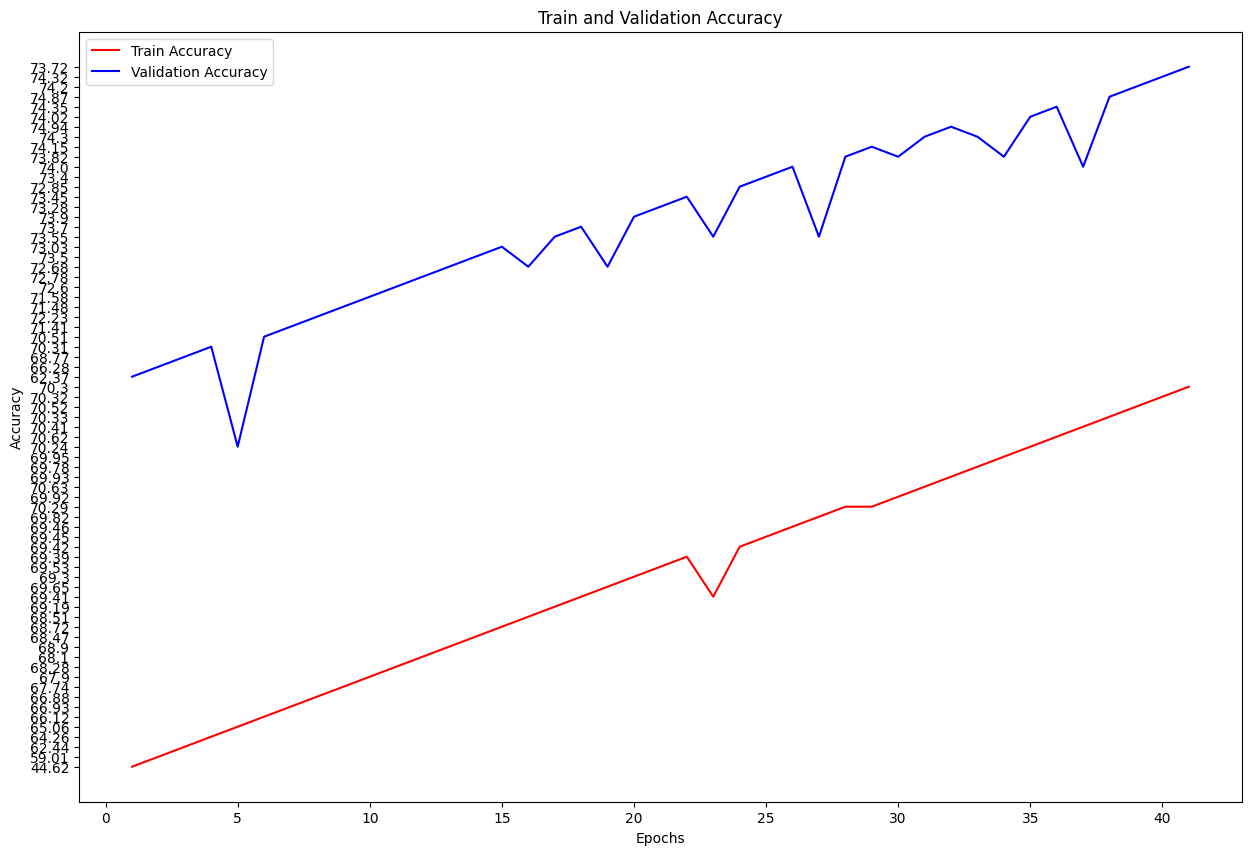

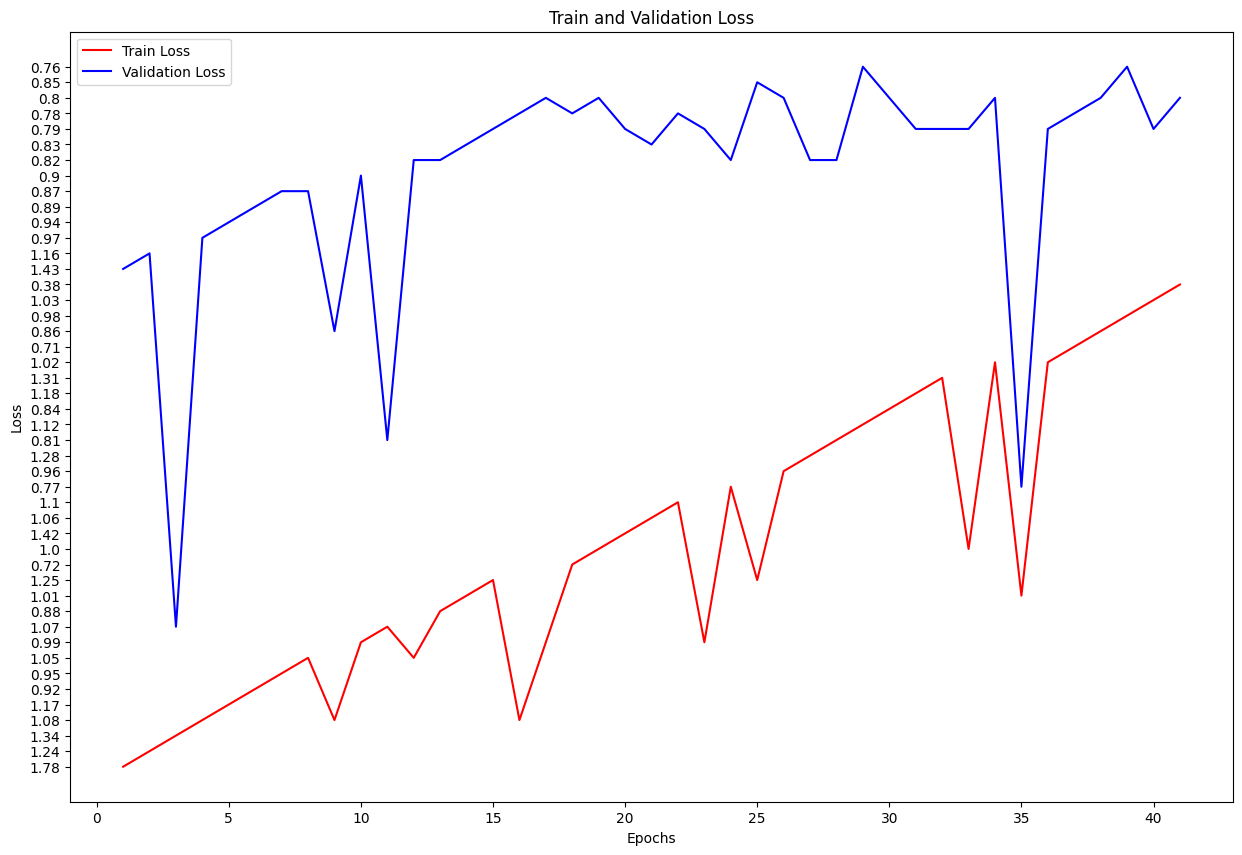

In [ ]:
epochs = range(1, len(train_accuracy_list) + 1)

if len(train_accuracy_list) < len(validation_accuracy_list):
  validation_accuracy_list.pop()

# Plot train and validation accuracy
plt.figure(figsize=(15, 10))
plt.plot(epochs, train_accuracy_list, 'r', label='Train Accuracy')
plt.plot(epochs, validation_accuracy_list, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

if len(train_loss_list) < len(validation_loss_list):
  validation_loss_list.pop()

# Plot train and validation loss
plt.figure(figsize=(15, 10))
plt.plot(epochs, train_loss_list, 'r', label='Train Loss')
plt.plot(epochs, validation_loss_list, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pt'))

<All keys matched successfully>

In [ ]:
#Test the model
model.eval()  # Set the model to evaluation mode

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Test Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

Test Accuracy: 73.46%
Precision: 0.73
Recall: 0.73
F1 Score: 0.73


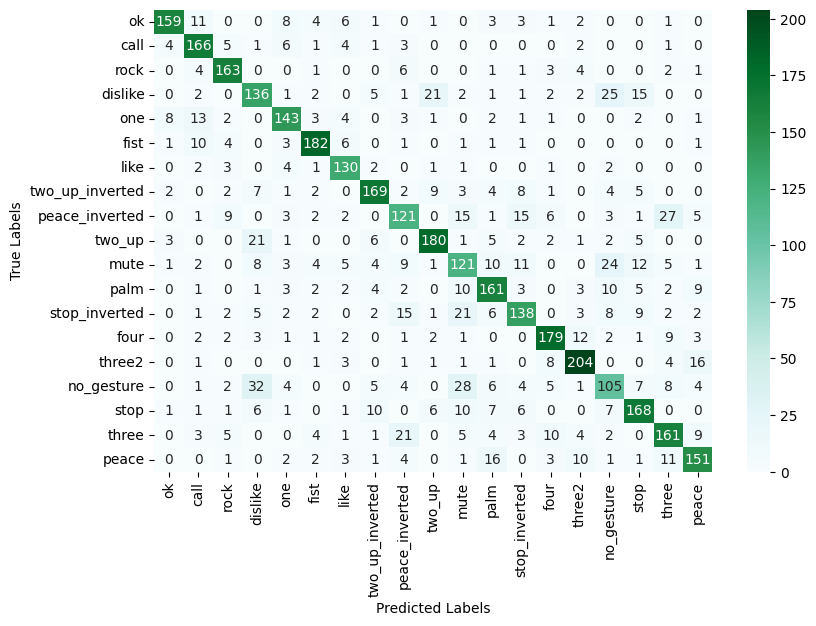

In [ ]:
# Plot the confusion matrix
c_m = confusion_matrix(true_labels, predicted_labels)
dataFrame = pd.DataFrame(c_m, class_list, class_list)

plt.figure(figsize = (9,6))
sn.heatmap(dataFrame, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

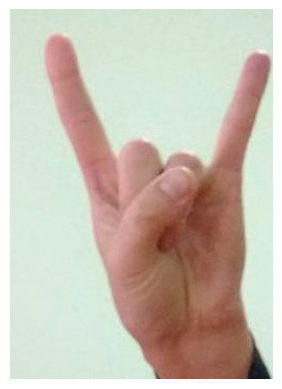

Predicted Class: stop_inverted
Confidence: 99.56551790237427 %
---------------------------------------
ok         0.00%
call       0.00%
rock       0.00%
dislike    0.00%
one        0.00%
fist       0.00%
like       0.00%
two_up_inverted 0.00%
peace_inverted 0.07%
two_up     0.00%
mute       0.35%
palm       0.00%
stop_inverted 99.57%
four       0.00%
three2     0.00%
no_gesture 0.00%
stop       0.01%
three      0.00%
peace      0.00%
---------------------------------------


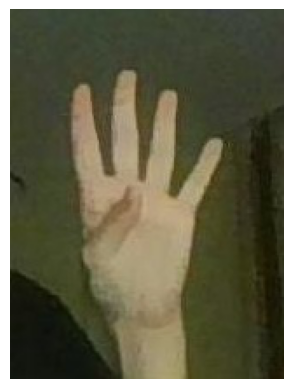

Predicted Class: dislike
Confidence: 39.702630043029785 %
---------------------------------------
ok         0.59%
call       0.14%
rock       0.09%
dislike    39.70%
one        1.29%
fist       0.03%
like       0.18%
two_up_inverted 0.67%
peace_inverted 1.46%
two_up     27.06%
mute       2.40%
palm       0.02%
stop_inverted 16.44%
four       0.93%
three2     0.15%
no_gesture 7.65%
stop       1.01%
three      0.17%
peace      0.02%
---------------------------------------


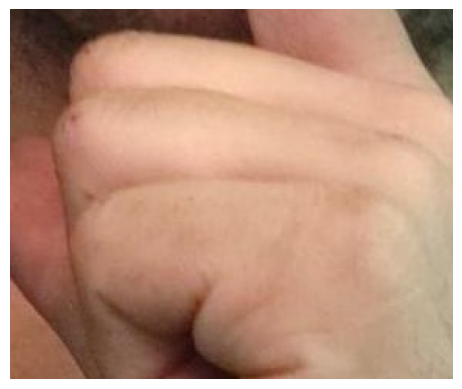

Predicted Class: call
Confidence: 63.41254711151123 %
---------------------------------------
ok         1.18%
call       63.41%
rock       13.59%
dislike    0.48%
one        8.86%
fist       1.66%
like       4.63%
two_up_inverted 0.13%
peace_inverted 2.33%
two_up     0.09%
mute       0.91%
palm       0.11%
stop_inverted 0.70%
four       0.29%
three2     0.08%
no_gesture 0.13%
stop       0.11%
three      1.22%
peace      0.09%
---------------------------------------


In [ ]:
# Randomly select three different classes
selected_classes = random.sample(class_list, k=3)

# Iterate over the selected classes and choose one random image from each class
for class_name in selected_classes:
    class_directory = os.path.join(cropped_dataset_path, class_name)
    image_list = os.listdir(class_directory)
    random_image = random.choice(image_list)
    image_path = os.path.join(class_directory, random_image)

    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((384, 384)),  # Resize the image to match the input size of your model
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    ])

    # Apply the transformations
    input_image = transform(image).unsqueeze(0)  # Add a batch dimension

    # Set the model in evaluation mode
    model.eval()

    # Pass the input image through the model
    with torch.no_grad():
        input_image = input_image.to(device)
        output = model(input_image)

    # Get the predicted class
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

    # Get the confidence of the prediction
    confidence = probabilities[0][predicted_class].item() * 100
    each_class_confidence = probabilities * 100

    # Print the predicted class and confidence
    print("Predicted Class:", class_list[predicted_class.item()])
    print("Confidence:", confidence, "%")

    print('---------------------------------------')
    for i, class_label in enumerate(class_list):
      print(f"{class_label:10s} {each_class_confidence[0, i]:.2f}%")
    print('---------------------------------------')